ERSIP Lab Sessions    
Lab 2: Point-based processing  
22-09-2025

In [ ]:
import numpy as np
import time
import rasterio

In [2]:
img = rasterio.open(r"Data\spot2005_pansharpened_utm33_subset_NIRRGMIR.tif")
input =img.read(1)

**Histogram tests**

Naive approach time: 11.0
Efficient approach time: 0.125
Efficient 2 approach time: 0.015625


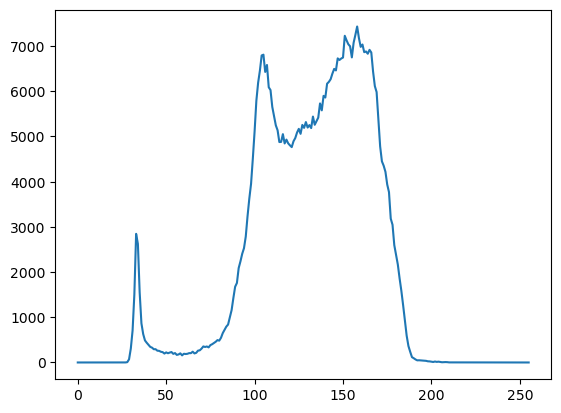

In [ ]:
# computing a histogram
# naive approach 
start = time.process_time()

hist=np.zeros(256,dtype=int)
values=input.flatten()
for v in range(len(hist)):
    for i in values:
        if i==v:
            hist[v]+=1

end = time.process_time()
print("Naive approach time:", end - start)

# efficient 
start = time.process_time()

hist=np.zeros(256,dtype=int)
values=input.flatten()
for i in values:
    hist[i]+=1

end = time.process_time()
print("Efficient approach time:", end - start)

# efficient 2
start = time.process_time()

hist=np.histogram(input,256,range=(0,255))[0]

end = time.process_time()
print("Efficient 2 approach time:", end - start)

# plot histogram
import matplotlib.pyplot as plt

plt.plot(hist)

**computing negative for our image**

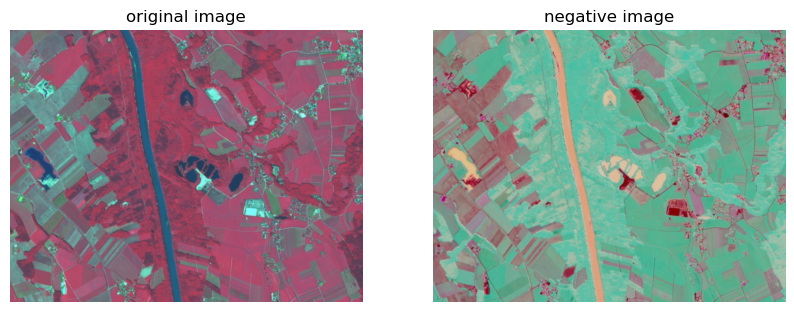

In [ ]:
#read image
# img = rasterio.open(r"Data\spot2005_pansharpened_utm33_subset_NIRRGMIR.tif")
input2 = img.read([1, 2, 3])  # shape: (3, H, W)

# Convert to OpenCV format (H, W, C)
rgb = np.transpose(input2, (1, 2, 0))

# Negate the original image (image is an 8-bit)
img_neg = 255 - rgb

# Display 
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(rgb)
axes[0].set_title("original image")
axes[0].axis("off")

axes[1].imshow(img_neg)
axes[1].set_title("negative image")
axes[1].axis("off")
plt.show()



**Without & with a LUT, apply a gamma correction aka power-law (report the efciency gain)**

gamma > 1 : narrows the range of dark values while widening the range of bright values.  
gamma < 1 : narrows the range of bright values while widening the range of dark values.

Gamma correction sans LUT(np) time: 0.0625


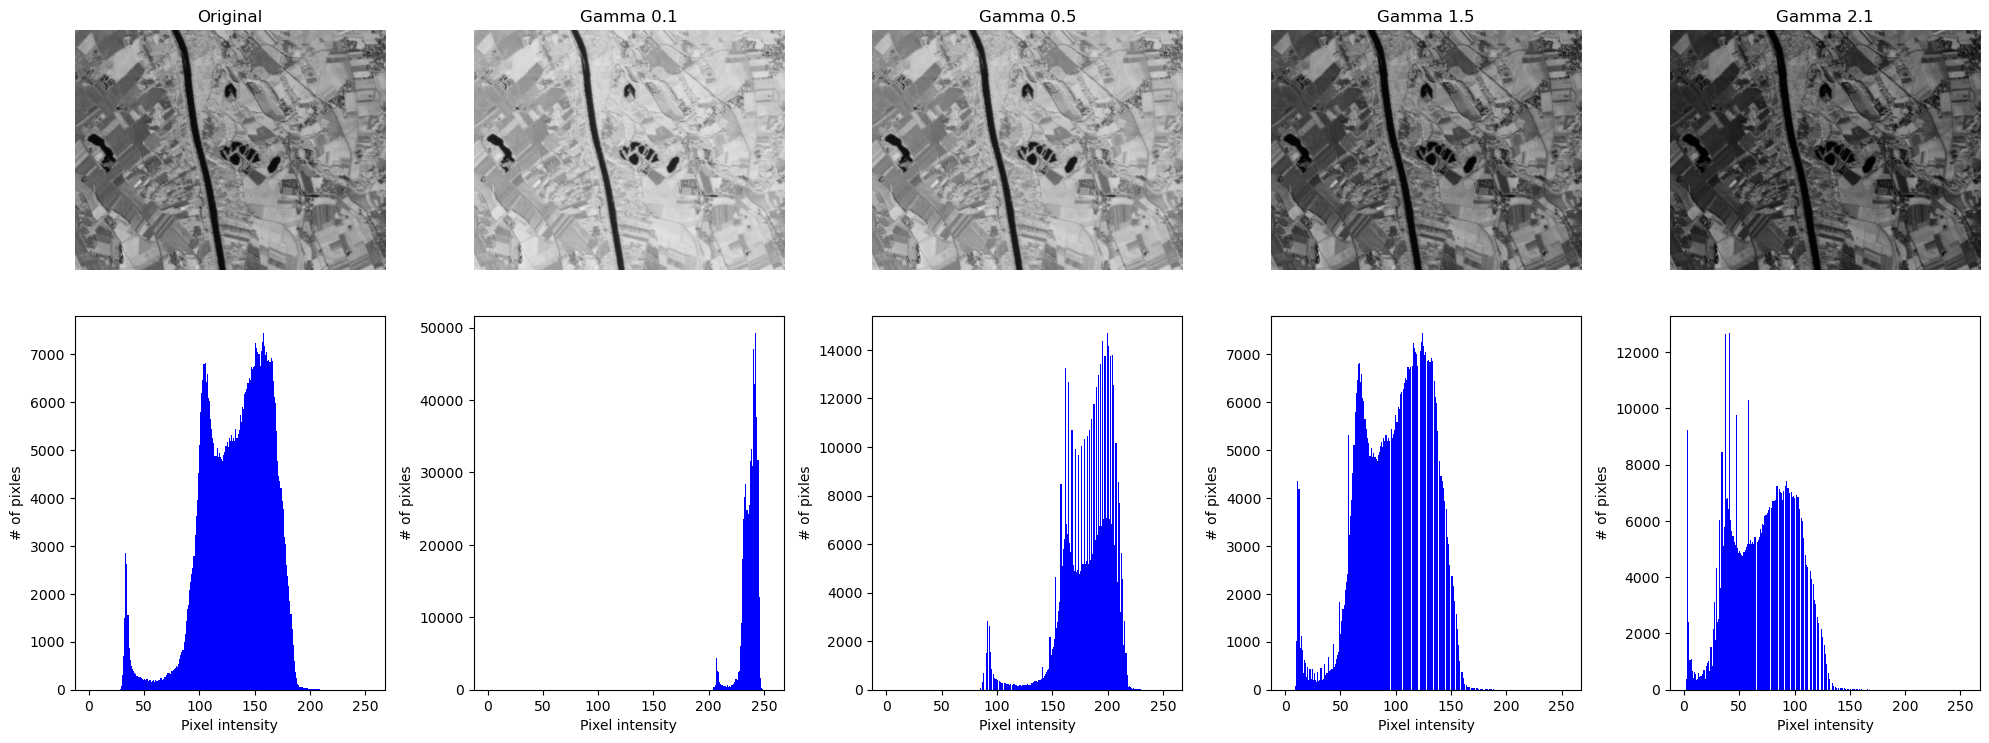

In [15]:
# without LUT
from skimage import exposure

start = time.process_time()

gammas = [0.1, 0.5, 1.5, 2.1]
gamma_images = [] 

# using skimage
# for g in gammas:
#     gamma_corrected = exposure.adjust_gamma(input, g)
#     gamma_images.append(gamma_corrected)

# end = time.process_time()
# print("Gamma correction sans LUT time:", end - start)

# using numpy
for g in gammas:
    # Gamma correction using NumPy
    gamma_corrected = (((input / 255.0) ** g) * 255).astype(np.uint8)
    gamma_images.append(gamma_corrected)
end = time.process_time()
print("Gamma correction sans LUT(np) time:", end - start)


# Display
images = [input] + gamma_images
titles = ['Original'] + [f'Gamma {g}' for g in gammas]

n = len(images)
fig, axes = plt.subplots(2, n, figsize=(4*n, 8))

# Flatten axes to 1D for easy indexing
axes = axes.flatten()

for i in range(n):
    # images
    axes[i].imshow(images[i], cmap='gray')
    axes[i].set_title(titles[i])
    axes[i].axis('off')

    # histogram (shift index by n to the bottom row)
    axes[i+n].hist(images[i].ravel(), bins=256, range=(0, 255), color='blue')
    axes[i+n].set_xlabel('Pixel intensity')
    axes[i+n].set_ylabel('# of pixles')

plt.tight_layout()
plt.show()

Gamma correction avec LUT time: 0.015625


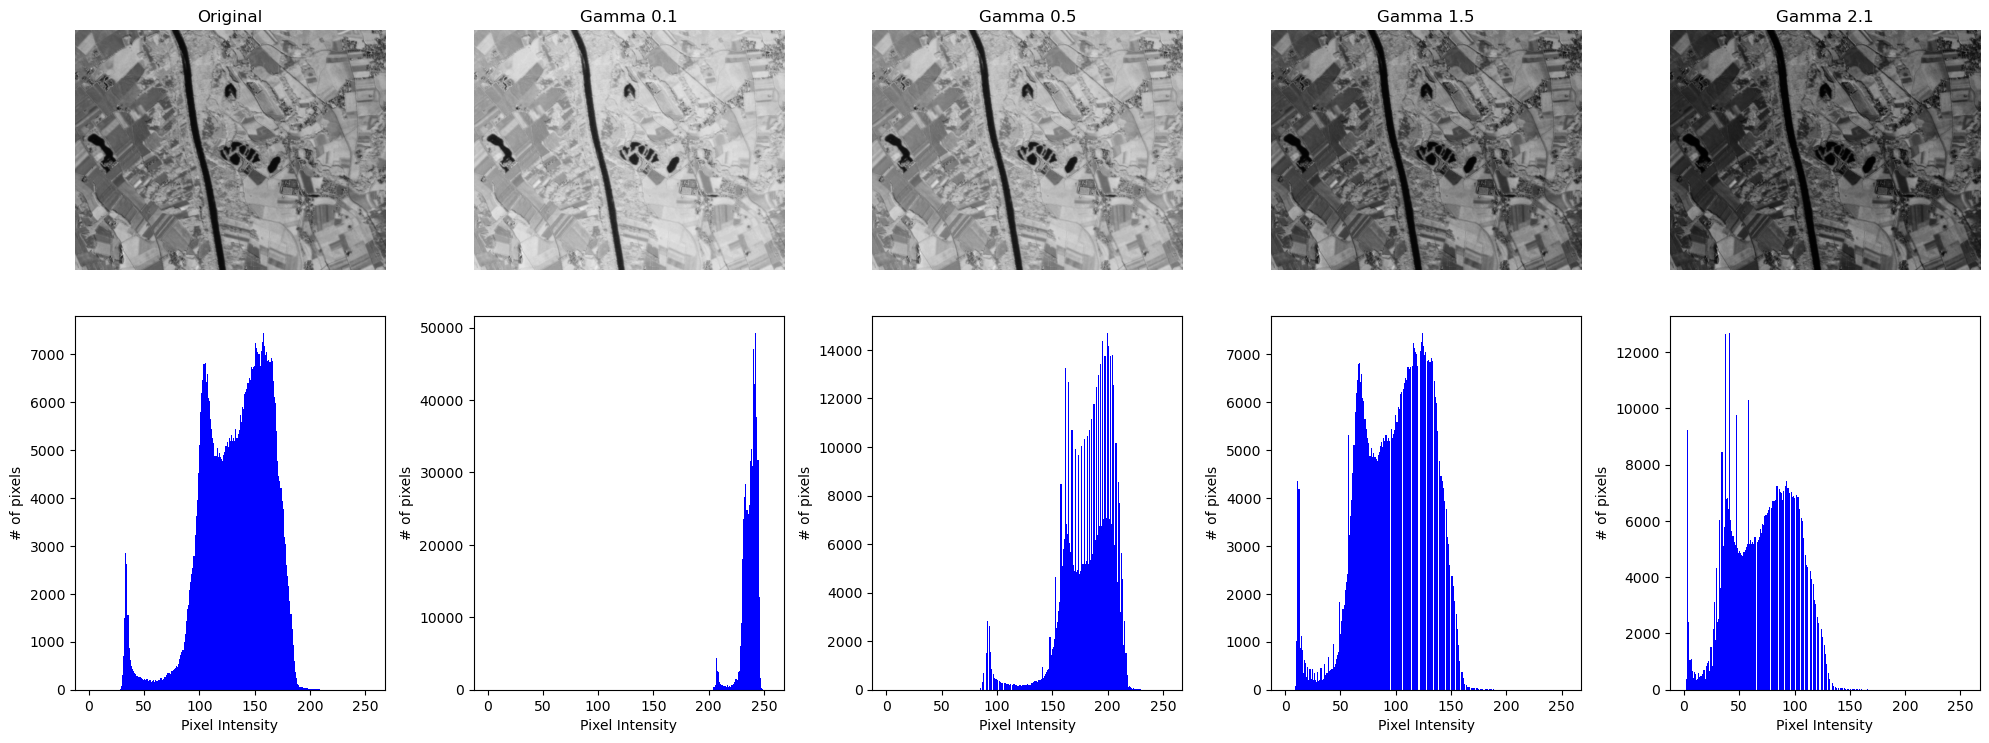

In [16]:
# with LUT
start = time.process_time()

gammas = [0.1, 0.5, 1.5, 2.1]
values = np.arange(256, dtype=np.uint8)
gamma_images_lut = []

# using skimage
# for g in gammas:
#     LUT = exposure.adjust_gamma(values, g)
#     gamma_images_lut.append(LUT[input])
# end = time.process_time()
# print("Gamma correction avec LUT time:", end - start)

# using numpy
for g in gammas:
    LUT = np.array([((i / 255.0) ** g) * 255 for i in values], dtype=np.uint8)
    gamma_images_lut.append(LUT[input])
end = time.process_time()
print("Gamma correction avec LUT time:", end - start)

# Display
images = [input] + gamma_images
titles = ['Original'] + [f'Gamma {g}' for g in gammas]

n = len(images)
fig, axes = plt.subplots(2, n, figsize=(4*n, 8))

# Flatten axes to 1D for easy indexing
axes = axes.flatten()

for i in range(n):
    # images
    axes[i].imshow(images[i], cmap='gray')
    axes[i].set_title(titles[i])
    axes[i].axis('off')

    # histogram (shift index by n to the bottom row)
    axes[i+n].hist(images[i].ravel(), bins=256, range=(0, 255), color='blue')
    axes[i+n].set_xlabel('Pixel Intensity')
    axes[i+n].set_ylabel('# of pixels')

plt.tight_layout()
plt.show()

*using `skimage.exposure.adjust_gamma` for gamma correction for this particular image resulted in similar processing time for both with or without LUT because our image is small. However using numpy approach shows the efficiency of using LUT in this smaller image*

**Code the histogram equalization function**

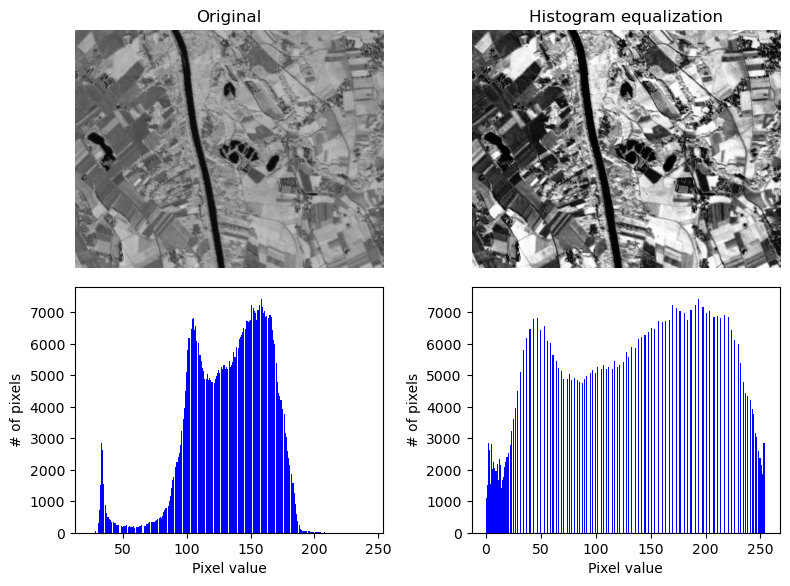

In [37]:
from skimage import exposure

# Histogram equalization
# img_eq = exposure.equalize_hist(input)

# using numpy
hist = np.histogram(input, bins=256, range=(0, 255))[0]  # histogram
cdf = hist.cumsum()  # cumulative CDF
cdf_normalized = ((cdf - cdf.min()) / (cdf.max() - cdf.min()) * 255).astype(np.uint8) # normalize CDF to 0-255
img_eq = cdf_normalized[input]

# Display
images = [input] + [img_eq]
titles = ['Original'] + ['Histogram equalization']

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Top row: images
for i in range(2):
    axes[0, i].imshow(images[i], cmap='gray')
    axes[0, i].set_title(titles[i])
    axes[0, i].axis('off')

# Bottom row: histograms
for i in range(2):
    axes[1, i].hist(images[i].ravel(), bins=256, color='blue')
    axes[1, i].set_xlabel('Pixel value')
    axes[1, i].set_ylabel('# of pixels')

plt.tight_layout()
plt.show()

**Check if histeq(negative(image))==negative(histeq(image))**   
*No. There is slight difference in the histogram mostly in the dark and bright values*

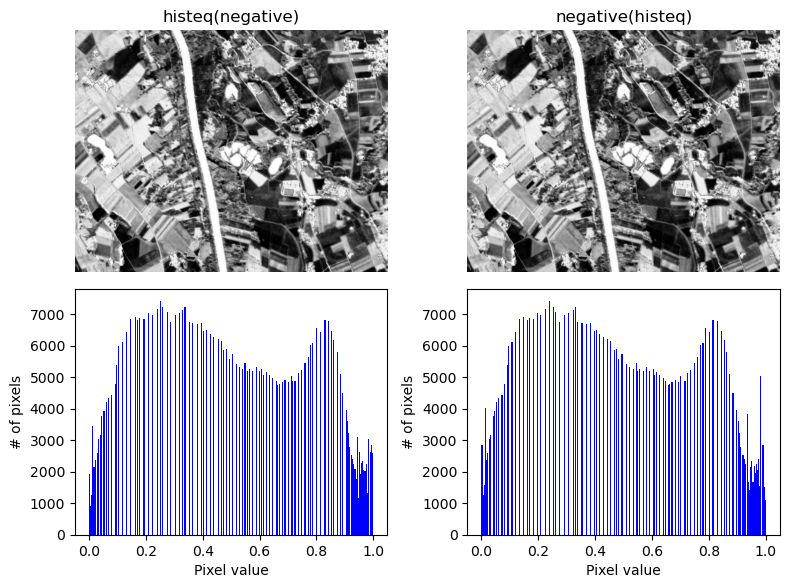

In [38]:
# histogram equalization of negative image
input_nm = input / 255.0 # normalize to 0-1
img_neg = 1 - input_nm
img_eq_neg = exposure.equalize_hist(img_neg)

# negate the histogram equalization image
img_eq = exposure.equalize_hist(input_nm)
img_eq_neg2 = 1 - img_eq

# Display
images = [img_eq_neg] + [img_eq_neg2]
titles = ['histeq(negative)'] + ['negative(histeq)']

fig, axes = plt.subplots(2, 2, figsize=(8,6))

for i in range(2):
    # images
    axes[0,i].imshow(images[i], cmap='gray')
    axes[0,i].set_title(titles[i])
    axes[0,i].axis('off')

    # histogram (shift index by n to the bottom row)
    axes[1,i].hist(images[i].ravel(), bins=256,color='blue')
    axes[1,i].set_xlabel('Pixel value')
    axes[1,i].set_ylabel('# of pixels')

plt.tight_layout()
plt.show()

**Perform a contrast stretch clipping the 5% extrema**    

*Pixels below the 5th percentile and above the 95th percentile were clipped and mapped to 0 and 255, respectively. This causes the histogram to show spikes at the extreme values.*

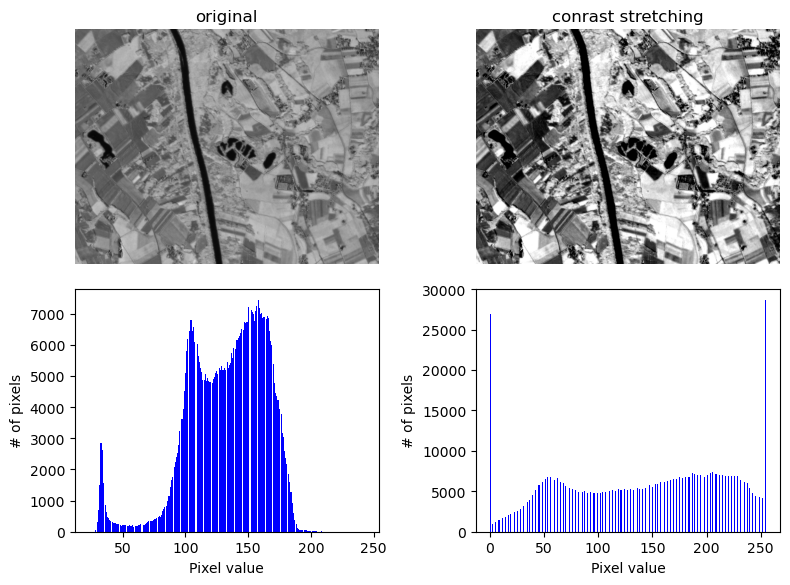

In [47]:
# contrast stretching
p5, p95 = np.percentile(input, (5, 95))
img_rescale = exposure.rescale_intensity(input, in_range=(p5, p95))

# Display
images = [input] + [img_rescale]
titles = ['original'] + ['conrast stretching']

fig, axes = plt.subplots(2, 2, figsize=(8,6))

for i in range(2):
    # images
    axes[0,i].imshow(images[i], cmap='gray')
    axes[0,i].set_title(titles[i])
    axes[0,i].axis('off')

    # histogram (shift index by n to the bottom row)
    axes[1,i].hist(images[i].ravel(), bins=256, color='blue')
    axes[1,i].set_xlabel('Pixel value')
    axes[1,i].set_ylabel('# of pixels')

plt.tight_layout()
plt.show()

**multi-image operators (e.g. NDVI extraction, change detection, RGB to gray)**

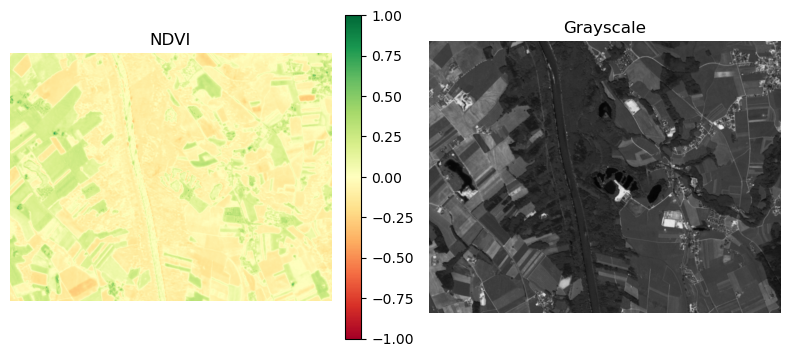

In [64]:
# NDVI extraction
red = (img.read(1))/255.0
NIR = (img.read(4))/255.0

NDVI = (NIR - red) / (NIR + red)

# RGB to gray
green = (img.read(2))/255.0
blue = (img.read(3))/255.0
gray = 0.2125*red + 0.7154*green + 0.0721*blue

#display
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# NDVI
im0 = axes[0].imshow(NDVI, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0].set_title("NDVI")
axes[0].axis("off")
plt.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04)

# Grayscale
axes[1].imshow(gray, cmap='gray')
axes[1].set_title("Grayscale")
axes[1].axis("off")


plt.tight_layout()
plt.show()